In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

In [2]:
# Change directory to autocd
os.chdir("../")
os.getcwd()

'/Users/gerlise/Documents/GitHub/AutoCD/autocd'

### Create tables

Creates the tables shown in the paper and also in the Appendix

In [5]:
def sort_columns(df, name):
    custom_sort = ["stars", "oct", "autocd", "autocd+", "autocd_pc", 
               "autocd_pc+", "pc", "fges", "lingam", "golem"]
    df_sorted = df[custom_sort]
    df_sorted.to_csv(f"visualizations/tables/{name}.csv")
    df_sorted.to_latex(f"visualizations/tables/{name}.tex")

result_dir = "bootstrap"
output_dir = f"tables"
os.makedirs(output_dir, exist_ok=True)

data = []
for dataset in os.listdir(f"{result_dir}/stars"):
    print(f"Dataset: {dataset}")

    if dataset == "mixed_9_adni":
        datapath = f"{result_dir}/stars/{dataset}/baseline.csv"

        bootstrap = pd.read_csv(datapath)
        bootstrap = bootstrap.drop(["config"], axis=1)
        bootstrap = bootstrap.drop(["edges"], axis=1)

        mean = bootstrap.mean(skipna=True).values.round(2).astype(float)
        std = bootstrap.std(skipna=True).values.round(2).astype(float)
        metric = [f"{m}$pm${s}" for m, s in zip(mean, std)]

        data.append((dataset, "stars", *metric))
    else:
        datapath = f"{result_dir}/stars/{dataset}/baseline.csv"

        bootstrap = pd.read_csv(datapath)
        bootstrap = bootstrap.drop(["config"], axis=1)

        mean = bootstrap.mean(skipna=True).values.round(2).astype(float)
        std = bootstrap.std(skipna=True).values.round(2).astype(float)
        metric = [f"{m}$pm${s}" for m, s in zip(mean, std)]

        data.append((dataset, "stars", *metric))

for dataset in os.listdir(f"{result_dir}/oct"):

    if dataset.startswith("continuous"):
        # autocd variants use StARS
        for file in os.listdir(f"{result_dir}/stars/{dataset}"):
            method = file.replace(".csv", "")

            if method.endswith("samples") or method.endswith("hours"):
                continue

            if method.startswith("autocd"):
                datapath = f"{result_dir}/stars/{dataset}/{file}"
                bootstrap = pd.read_csv(datapath)
                bootstrap = bootstrap.drop(["config"], axis=1)

                mean = bootstrap.mean(skipna=True).values.round(2).astype(float)
                std = bootstrap.std(skipna=True).values.round(2).astype(float)
                metric = [f"{m}$pm${s}" for m, s in zip(mean, std)]

                data.append((dataset, method, *metric))
            else:
                datapath = f"{result_dir}/oct/{dataset}/{file}"
                bootstrap = pd.read_csv(datapath)
                bootstrap = bootstrap.drop(["config"], axis=1)

                mean = bootstrap.mean(skipna=True).values.round(2).astype(float)
                std = bootstrap.std(skipna=True).values.round(2).astype(float)
                metric = [f"{m}$pm${s}" for m, s in zip(mean, std)]

                if method == "baseline":
                    method = "oct"
                data.append((dataset, method, *metric))
    elif dataset == "mixed_9_adni":
        for file in os.listdir(f"{result_dir}/oct/{dataset}"):
            method = file.replace(".csv", "")
            datapath = f"{result_dir}/oct/{dataset}/{file}"

            bootstrap = pd.read_csv(datapath)
            bootstrap = bootstrap.drop(["config"], axis=1)
            bootstrap = bootstrap.drop(["edges"], axis=1)

            mean = bootstrap.mean(skipna=True).values.round(2).astype(float)
            std = bootstrap.std(skipna=True).values.round(2).astype(float)
            metric = [f"{m}$pm${s}" for m, s in zip(mean, std)]
            
            if method == "baseline":
                method = "oct"
            data.append((dataset, method, *metric))
    else:
        for file in os.listdir(f"{result_dir}/oct/{dataset}"):
            method = file.replace(".csv", "")

            if method.endswith("samples") or method.endswith("hours"):
                continue
            
            datapath = f"{result_dir}/oct/{dataset}/{file}"

            bootstrap = pd.read_csv(datapath)
            bootstrap = bootstrap.drop(["config"], axis=1)

            mean = bootstrap.mean(skipna=True).values.round(2).astype(float)
            std = bootstrap.std(skipna=True).values.round(2).astype(float)
            metric = [f"{m}$pm${s}" for m, s in zip(mean, std)]

            if method == "baseline":
                method = "oct"
            data.append((dataset, method, *metric))

columns = [
    "dataset", "method", "loss", "shd", "ca", "fp", "fn",
]

df_data = pd.DataFrame(data, columns=columns)
df_data.set_index("dataset", inplace=True)
df_pivot = df_data.pivot(columns="method")

df_loss = sort_columns(df_pivot["loss"], "loss")
df_shd = sort_columns(df_pivot["shd"], "shd")
df_ca = sort_columns(df_pivot["ca"], "ca")
df_fp = sort_columns(df_pivot["fp"], "fp")
df_fn = sort_columns(df_pivot["fn"], "fn")

Dataset: mixed_9_shen
Dataset: continuous_40_2
Dataset: mixed_40_2
Dataset: discrete_30_2
Dataset: continuous_40_3
Dataset: discrete_30_3
Dataset: mixed_40_3
Dataset: continuous_40_4
Dataset: mixed_40_4
Dataset: discrete_30_4
Dataset: discrete_20_3
Dataset: discrete_20_4
Dataset: continuous_10_2
Dataset: mixed_10_2
Dataset: continuous_10_4
Dataset: mixed_10_4
Dataset: continuous_10_3
Dataset: mixed_10_3
Dataset: discrete_20_2
Dataset: discrete_5_2
Dataset: mixed_5_2
Dataset: mixed_5_3
Dataset: discrete_5_4
Dataset: mixed_5_4
Dataset: discrete_5_3
Dataset: continuous_5_4
Dataset: continuous_5_3
Dataset: continuous_5_2
Dataset: discrete_10_3
Dataset: discrete_10_4
Dataset: mixed_20_2
Dataset: continuous_20_2
Dataset: mixed_20_4
Dataset: continuous_20_4
Dataset: mixed_20_3
Dataset: continuous_20_3
Dataset: discrete_10_2
Dataset: mixed_30_4
Dataset: discrete_40_4
Dataset: continuous_30_4
Dataset: discrete_40_3
Dataset: mixed_30_3
Dataset: continuous_30_3
Dataset: mixed_30_2
Dataset: discre

### Test significance with Wilcoxon signed rank test

The results in bold are tested using this test

In [17]:
metric = "shd"
dataset = "mixed_5_3"

if dataset.startswith("continuous"):
    obj = "stars"
    lingam = pd.read_csv(f"bootstrap/oct/{dataset}/lingam.csv")[metric]
    golem = pd.read_csv(f"bootstrap/oct/{dataset}/golem.csv")[metric]
else:
    obj = "oct"

stars = pd.read_csv(f"bootstrap/stars/{dataset}/baseline.csv")[metric]
oct = pd.read_csv(f"bootstrap/oct/{dataset}/baseline.csv")[metric]
autocd = pd.read_csv(f"bootstrap/{obj}/{dataset}/autocd.csv")[metric]
autocd_plus = pd.read_csv(f"bootstrap/{obj}/{dataset}/autocd+.csv")[metric]
autocd_pc = pd.read_csv(f"bootstrap/{obj}/{dataset}/autocd_pc.csv")[metric]
autocd_pc_plus = pd.read_csv(f"bootstrap/{obj}/{dataset}/autocd_pc+.csv")[metric]
pc = pd.read_csv(f"bootstrap/oct/{dataset}/pc.csv")[metric]
fges = pd.read_csv(f"bootstrap/oct/{dataset}/fges.csv")[metric]

statistic, pvalue = wilcoxon(autocd_pc, fges, zero_method="pratt")
print(f"Significant difference: {pvalue < 0.05}") 

Significant difference: True


### Ranking

AutoCD_StARS vs AutoCD_OCT

In [21]:
metrics = ["shd", "accuracy"]
data_types = ["continuous", "discrete", "mixed"]

for metric, data_type in itertools.product(metrics, data_types):
    print(metric, data_type)
    autocd_stars = []
    autocd_oct = []

    for dataset in os.listdir("bootstrap/stars"):
        if dataset == "mixed_9_adni":
            continue
        if dataset.startswith(data_type):
            autocd_stars.extend(pd.read_csv(f"bootstrap/stars/{dataset}/autocd.csv")[metric])

    for dataset in os.listdir("bootstrap/oct"):
        if dataset == "mixed_9_adni":
            continue
        if dataset.startswith(data_type):
            autocd_oct.extend(pd.read_csv(f"bootstrap/oct/{dataset}/autocd.csv")[metric])


    data = {"AutoCD_stars": autocd_stars, "AutoCD_oct": autocd_oct}
    df_rank = pd.DataFrame(data)
    ranks = df_rank.rank(axis=1, na_option='bottom", ascending=((metric != "accuracy")))
    print(ranks.mean())

shd continuous
AutoCD_stars    1.302133
AutoCD_oct      1.697867
dtype: float64
shd discrete
AutoCD_stars    1.9883
AutoCD_oct      1.0117
dtype: float64
shd mixed
AutoCD_stars    1.577867
AutoCD_oct      1.422133
dtype: float64
accuracy continuous
AutoCD_stars    1.305867
AutoCD_oct      1.694133
dtype: float64
accuracy discrete
AutoCD_stars    1.987733
AutoCD_oct      1.012267
dtype: float64
accuracy mixed
AutoCD_stars    1.647533
AutoCD_oct      1.352467
dtype: float64


Ranking of all methods

In [165]:
metrics = ["shd", "accuracy"]

for metric in metrics:
    print(metric)
    
    stars = []
    oct = []
    autocd = []
    autocd_plus = []
    autocd_pc = []
    autocd_pc_plus = []
    pc = []
    fges = []
    for dataset in os.listdir("bootstrap/stars"):
        if dataset == "mixed_9_adni" or dataset == ".DS_Store":
            continue
        stars.extend(pd.read_csv(f"bootstrap/stars/{dataset}/baseline.csv")[metric])

    for dataset in os.listdir("bootstrap/oct"):
        if dataset == "mixed_9_adni" or dataset == ".DS_Store":
            continue
        oct.extend(pd.read_csv(f"bootstrap/oct/{dataset}/baseline.csv")[metric])

        if dataset.startswith("continuous"):
            autocd.extend(pd.read_csv(f"bootstrap/stars/{dataset}/autocd.csv")[metric])
            autocd_plus.extend(pd.read_csv(f"bootstrap/stars/{dataset}/autocd+.csv")[metric])
            autocd_pc.extend(pd.read_csv(f"bootstrap/stars/{dataset}/autocd_pc.csv")[metric])
            autocd_pc_plus.extend(pd.read_csv(f"bootstrap/stars/{dataset}/autocd_pc+.csv")[metric])
            pc.extend(pd.read_csv(f"bootstrap/oct/{dataset}/pc.csv")[metric])
            fges.extend(pd.read_csv(f"bootstrap/oct/{dataset}/fges.csv")[metric])
        else:
            autocd.extend(pd.read_csv(f"bootstrap/oct/{dataset}/autocd.csv")[metric])
            autocd_plus.extend(pd.read_csv(f"bootstrap/oct/{dataset}/autocd+.csv")[metric])
            autocd_pc.extend(pd.read_csv(f"bootstrap/oct/{dataset}/autocd_pc.csv")[metric])
            autocd_pc_plus.extend(pd.read_csv(f"bootstrap/oct/{dataset}/autocd_pc+.csv")[metric])
            pc.extend(pd.read_csv(f"bootstrap/oct/{dataset}/pc.csv")[metric])
            fges.extend(pd.read_csv(f"bootstrap/oct/{dataset}/fges.csv")[metric])


    data = {"StARS": stars, "OCT": oct, "AutoCD": autocd, "AutoCD+": autocd_plus, 
            "AutoCD_PC": autocd_pc, "AutoCD_PC+": autocd_pc_plus, "PC": pc, "FGES": fges}
    df_rank = pd.DataFrame(data)
    ranks = df_rank.rank(axis=1, na_option="bottom", ascending=((metric != "accuracy")))
    print(ranks.mean())

shd
StARS         5.327978
OCT           5.213100
AutoCD        3.783656
AutoCD+       4.124678
AutoCD_PC     3.688578
AutoCD_PC+    4.252978
PC            4.360744
FGES          5.248289
dtype: float64
accuracy
StARS         5.375589
OCT           5.205933
AutoCD        3.797578
AutoCD+       4.131500
AutoCD_PC     3.721722
AutoCD_PC+    4.273544
PC            4.327922
FGES          5.166211
dtype: float64


### Increase data samples evaluation

This creates the Figure 1 and Figure 6

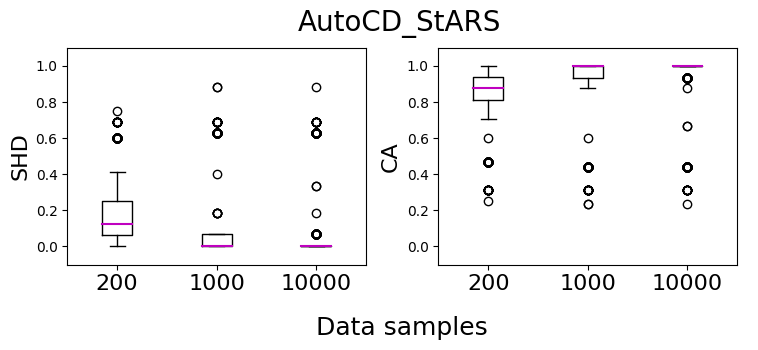

In [45]:
def load_data(metric, data_path):
    df_200 = pd.read_csv(f"{data_path}/autocd_200_samples.csv")[metric]
    df_1000 = pd.read_csv(f"{data_path}/autocd.csv")[metric]
    df_10_000 = pd.read_csv(f"{data_path}/autocd_10000_samples.csv")[metric]
    df = pd.concat([df_200, df_1000, df_10_000], axis=1)
    df.columns = ["200", "1000", "10000"]
    return df

stars_path = "bootstrap/stars/continuous_10_3"
# oct_path = "bootstrap/oct/continuous_10_3"

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
axs = axs.flatten()

axs[0].boxplot(load_data("shd", stars_path), medianprops=dict(color="m", linewidth=1.5))
axs[0].set_xticklabels(labels=["200", "1000", "10000"], fontsize=14)
axs[0].set_ylabel("SHD", fontsize=16)
axs[0].set_ylim(-0.1, 1.1)

axs[1].boxplot(load_data("accuracy", stars_path), medianprops=dict(color="m", linewidth=1.5))
axs[1].set_xticklabels(labels=["200", "1000", "10000"], fontsize=14)
axs[1].set_ylabel("CA", fontsize=16)
axs[1].set_ylim(-0.1, 1.1)

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.text(1.11, 1.11, "AutoCD_StARS", ha="center", va='center', transform=axs[0].transAxes, fontsize=20)
plt.xlabel("Data samples", labelpad=20, fontsize=18)

plt.tight_layout()
plt.savefig("visualizations/data_sample_stars.pdf")
plt.show()

### AutoCD's performance on discrete, continuous, mixed dataset

This creates Figure 2

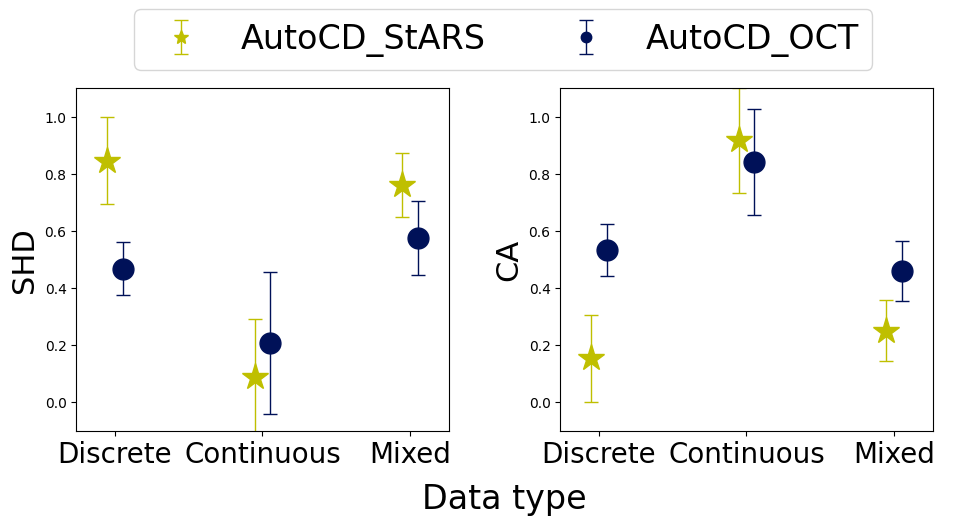

In [167]:
def load_data(metric, dataset):
    df_stars = pd.read_csv(f"bootstrap/stars/{dataset}/autocd.csv")[metric]
    df_oct = pd.read_csv(f"bootstrap/oct/{dataset}/autocd.csv")[metric]
    
    df = pd.concat([df_stars, df_oct], axis=1)
    df.columns = ["stars", "oct"]
    return df

def plot_types(ax, df_dis, df_con, df_mix, metric):
    column = ["stars", "oct"]
    label = ["StARS", "OCT"]
    marker = ["*", "o"]
    size_m = [20, 15]
    color = ["y", (0, 17/256.0, 88/256.0)]
    for i in range(2):
        ax.errorbar(1.05 - 0.05 + i * 0.1, np.mean(df_dis[column[i]]), np.std(df_dis[column[i]]), fmt=marker[i], markersize=size_m[i],
                        color=color[i], ecolor=color[i], elinewidth=1, capsize=5, label=label[i])
        ax.errorbar(2 - 0.05 + i * 0.1, np.mean(df_con[column[i]]), np.std(df_con[column[i]]), fmt=marker[i], markersize=size_m[i],
                        color=color[i], ecolor=color[i], elinewidth=1, capsize=5)
        ax.errorbar(2.95 - 0.05 + i * 0.1, np.mean(df_mix[column[i]]), np.std(df_mix[column[i]]), fmt=marker[i], markersize=size_m[i],
                        color=color[i], ecolor=color[i], elinewidth=1, capsize=5)
        
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0.8, 3.2)
    ax.set_xticks([1.05, 2, 2.95])
    ax.set_xticklabels(["Discrete", "Continuous", "Mixed"], fontsize=20)
    ax.set_ylabel(f"{metric}", fontsize=22)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

df_dis_shd = load_data("shd", "discrete_10_3")
df_con_shd = load_data("shd", "continuous_10_3")
df_mix_shd = load_data("shd", "mixed_10_3")
df_dis_acc = load_data("accuracy", "discrete_10_3")
df_con_acc = load_data("accuracy", "continuous_10_3")
df_mix_acc = load_data("accuracy", "mixed_10_3")

plot_types(axs[0], df_dis_shd, df_con_shd, df_mix_shd, "SHD")
plot_types(axs[1], df_dis_acc, df_con_acc, df_mix_acc, "CA")
plt.subplots_adjust(wspace=0.3, left=0.1, right=0.9, bottom=0.1, top=0.9)

legend_labels = ["AutoCD_StARS", "AutoCD_OCT"]
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, markerscale=0.5, fontsize=24, loc='upper center', ncol=2, bbox_to_anchor=(0.54, 1.15))

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Data type", labelpad=20, fontsize=24)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"datatype.pdf", bbox_inches='tight')
plt.show()


### Increase budget of SMAC

This create Figure 3

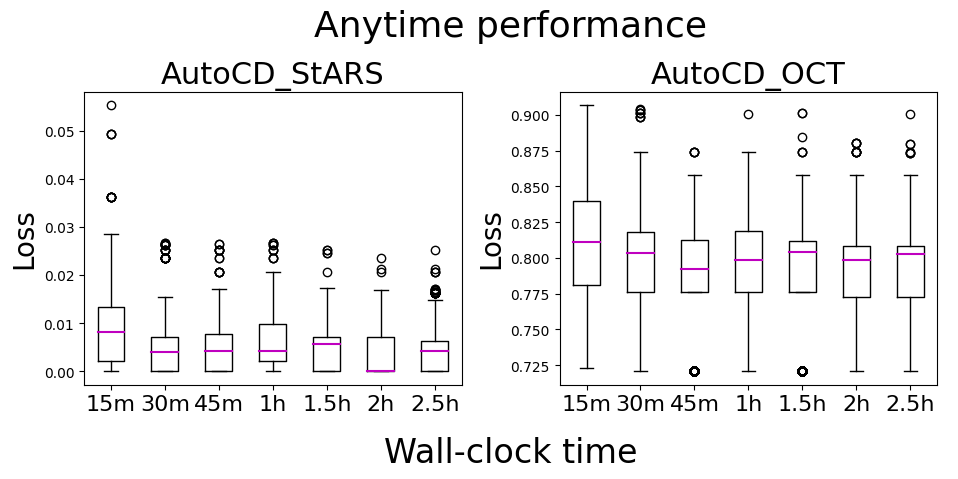

In [289]:
def load_data(metric, data_path):
    df_15m = pd.read_csv(f"additional_results/{data_path}/autocd_15_minutes.csv")[metric]   
    df_15m.fillna(1, inplace=True)
    df_30m = pd.read_csv(f"additional_results/{data_path}/autocd_30_minutes.csv")[metric]
    df_30m.fillna(1, inplace=True)
    df_45m = pd.read_csv(f"additional_results/{data_path}/autocd_45_minutes.csv")[metric]
    df_45m.fillna(1, inplace=True)
    df_1h = pd.read_csv(f"{data_path}/autocd.csv")[metric]
    df_1h.fillna(1, inplace=True)
    df_1h30m = pd.read_csv(f"{data_path}/autocd_15_hours.csv")[metric]
    df_1h30m.fillna(1, inplace=True)
    df_2h = pd.read_csv(f"{data_path}/autocd_2_hours.csv")[metric]
    df_2h.fillna(1, inplace=True)
    df_2h30m = pd.read_csv(f"{data_path}/autocd_25_hours.csv")[metric]
    df_2h30m.fillna(1, inplace=True)

    df = pd.concat([df_15m, df_30m, df_45m, df_1h, df_1h30m, df_2h, df_2h30m], axis=1)
    df.columns = ["15m", "30m", "45m", "1h", "1.5h", "2h", "2.5h"]
    return df

def plot_types(ax, metric, datapath):
    df = load_data(metric, datapath)
    ax.boxplot(df, medianprops=dict(color="m", linewidth=1.5))
    ax.set_xticklabels(labels=["15m", "30m", "45m", "1h", "1.5h", "2h", "2.5h"], fontsize=16)
    
    if metric == "stars":
        metric = "StARS"
    else:
        metric = "OCT"
    
    ax.set_ylabel(f"Loss", fontsize=20)
    ax.set_title(f"AutoCD_{metric}", fontsize=22)


fig, axs = plt.subplots(1, 2, figsize=(10, 5.5))

plot_types(axs[0], "stars", f"bootstrap/stars/mixed_10_3")
plot_types(axs[1], "oct", f"bootstrap/oct/mixed_10_3")

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Wall-clock time", labelpad=20, fontsize=24)
plt.title("Anytime performance", fontsize=26, pad=40)

plt.tight_layout()
plt.savefig(f"visualizations/budget_mixed.pdf")
plt.show()

Show trajectory of trials and incumbents in SMAC and creates Figure 4

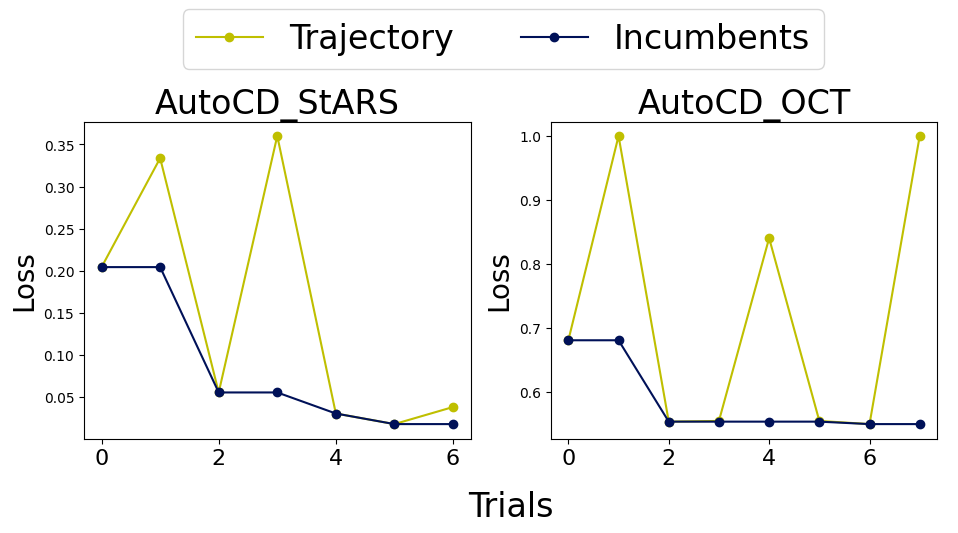

In [164]:
from utils import load_json

def get_losses(data_path):
    loss = []
    trajectory = load_json(data_path)
    for t in trajectory["data"]:
        if t[4] == np.inf:
            loss.append(np.nan)
        else:
            loss.append(t[4])
    df_loss = pd.DataFrame(loss)
    df_loss.fillna(1, inplace=True)
    return df_loss

def get_incumbent(data_path, length):
    loss = [None] * length
    df = pd.DataFrame(load_json(data_path)["trajectory"]) 
    trial_list = df['trial'].tolist()
    cost_list = df['costs'].tolist()
    
    for i in range(1, length + 1):
        for trial, cost in zip(trial_list, cost_list):
            if i == trial or (i > trial and i != 1):
                loss[i - 1] = cost[0]
    return pd.DataFrame(loss)

datapath = "output/stars/continuous_10_3/autocd"
traj = get_losses(f"{datapath}/run_6/6/runhistory.json")
incum = get_incumbent(f"{datapath}/run_6/6/intensifier.json", len(traj))
df_stars = pd.concat([traj, incum], axis=1)
df_stars.columns = ["Trajectory", "Incumbent"]

datapath = "output/oct/continuous_10_3/autocd"
traj = get_losses(f"{datapath}/run_21/21/runhistory.json")
incum = get_incumbent(f"{datapath}/run_21/21/intensifier.json", len(traj))
df_oct = pd.concat([traj, incum], axis=1)
df_oct.columns = ["Trajectory", "Incumbent"]

def plot_traj(ax, df, obj):
    colors = ["y", (0, 17/256.0, 88/256.0)]
    for color,  column in zip(colors, df.columns):
        ax.plot(df.index, df[column], marker='o', label=column, color=color)

    if obj == "stars":
        obj = "StARS"
    else:
        obj = "OCT"

    ax.set_xticks(np.arange(len(df), step=2), np.arange(len(df), step=2), fontsize=16)
    ax.set_ylabel(f"Loss", fontsize=20)
    ax.set_title(f"AutoCD_{obj}", fontsize=24)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey="col")

plot_traj(axs[0], df_stars, "stars")
plot_traj(axs[1], df_oct, "oct")

legend_labels = ["Trajectory", "Incumbents"]
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, fontsize=24, loc='upper center', ncol=2, bbox_to_anchor=(0.54, 1.15))

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Trials", labelpad=20, fontsize=24)

plt.tight_layout()
plt.savefig(f"visualizations/trajectory.pdf", bbox_inches="tight")
plt.show()